<a href="https://colab.research.google.com/github/avpai-dinosaur/gender_classification/blob/main/reu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries.

In [ ]:
import os
import PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Load the image data sets. We are using the [GENDER-COLOR-FERET dataset](https://mivia.unisa.it/datasets/video-analysis-datasets/gender-recognition-dataset/) from Mivia Lab of the University of Salerno. This is a balanced subset of the COLOR-FERET dataset, adapted for gender recogntion purposes. In this case the images are coloured and the dataset is composed by 836 faces. The dataset is completely balanced, since both the training and the test set are composed of 209 male and 209 female faces. 

Uploaded the dataset as zip file to Google Drive and unzipped.

In [ ]:
# !unzip -uq "/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET.zip" -d "/content/drive/MyDrive/(8) Summer 2023 REU"

In [ ]:
# put path to dataset in this variable
DATASET_PATH = "/content/drive/MyDrive/(8) Summer 2023 REU/GENDER-COLOR-FERET"

(!! Files already renamed so don't need to run this again !!) Renaming the file to number the images in order in a consistent format. 

In [ ]:
def name_file_number(num):
  num = str(num)
  if len(num) == 1:
    return "000" + num
  elif len(num) == 2:
    return "00" + num
  else:
    return "0" + num

def rename_images():
  dataset_directory = DATASET_PATH
  num_images = 0
  for test_train_split in os.listdir(dataset_directory):
    for gender in os.listdir(dataset_directory + "/" + test_train_split):
      for file in os.listdir(dataset_directory + "/" + test_train_split + "/" + gender):
        new_filename = name_file_number(num_images) + ".jpg"
        os.rename(dataset_directory + "/" + test_train_split + "/" + gender + "/" + file, 
                  dataset_directory + "/" + test_train_split + "/" + gender + "/" + new_filename)
        num_images += 1
  return

# rename_images()


Get the image dimensions and save in a constant variable.

In [ ]:
im = PIL.Image.open(DATASET_PATH + "/training_set/female/0418.jpg")
IMAGE_SIZE = (im.size[1], im.size[0]) # (height, width)
print(IMAGE_SIZE)

(768, 512)


Load training, validation, and testing data using tf.keras utility functions. Generate a 80/20 train/validation split.

In [ ]:
training_set = DATASET_PATH + "/training_set"
test_set = DATASET_PATH + "/test_set"
batch_size = 32
train_data = tf.keras.utils.image_dataset_from_directory(
  training_set,
  label_mode="binary",
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMAGE_SIZE,
  batch_size=batch_size)

validation_data = tf.keras.utils.image_dataset_from_directory(
  training_set,
  label_mode="binary",
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMAGE_SIZE,
  batch_size=batch_size)
  
test_data = tf.keras.utils.image_dataset_from_directory(
  test_set,
  label_mode="binary",
  seed=123,
  shuffle=True,
  image_size=IMAGE_SIZE,
  batch_size=batch_size)

Found 418 files belonging to 2 classes.
Using 335 files for training.
Found 418 files belonging to 2 classes.
Using 83 files for validation.
Found 418 files belonging to 2 classes.


Visualize the images and labels from the training set before preprocessing.

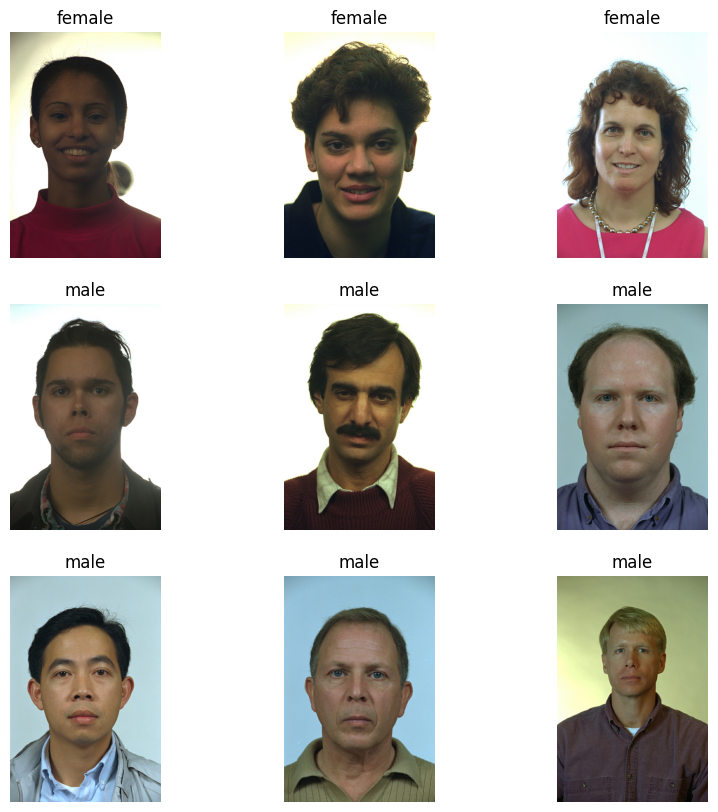

In [ ]:
class_names = train_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = labels[i].numpy().astype("uint8")
    plt.title(class_names[label[-1]])
    plt.axis("off")

The original dimensions of the images are very large and result in a long training time. Thus we will preprocess images for some performance by resizing them to 128 x 86 pixels.

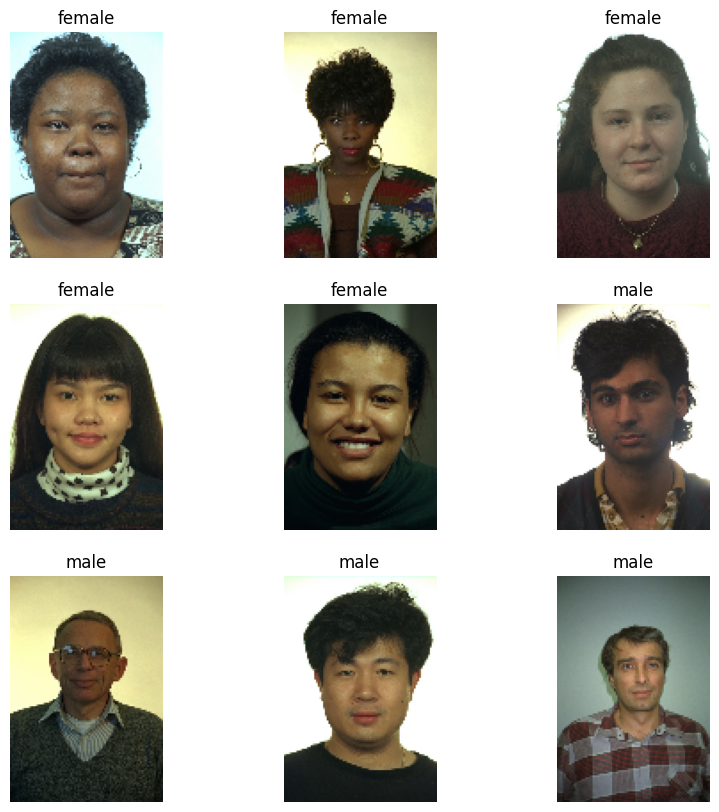

In [ ]:
# Create resize input layer and visualize how it changes images
RESIZE_IMAGE_DIMENSIONS = (128, 86)
resize_inputs = tf.keras.layers.Resizing(RESIZE_IMAGE_DIMENSIONS[0], RESIZE_IMAGE_DIMENSIONS[1])
class_names = train_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    result = resize_inputs(images[i])
    plt.imshow(result.numpy().astype("uint8"))
    label = labels[i].numpy().astype("uint8")
    plt.title(class_names[label[-1]])
    plt.axis("off")

Configure the dataset for performance based on documentation. Don't totally understand this but it has something to do with avoiding I/O blocking when loading batches from the disk.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
validation_datas = validation_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

Load a pre-trained EfficientNetV2B0 classifier to use as a feature extractor. This is a convolutional network trained on the ImageNet dataset, so we hypothesize that it is a good feature extractor for an image classification task.

The feature extractor converts a (128, 86, 3) image into a (4, 3, 1280) block of features.



In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, 
                                               weights="imagenet", 
                                               input_shape=RESIZE_IMAGE_DIMENSIONS + (3,))

image_batch, label_batch = next(iter(train_data))
resize_image_batch = resize_inputs(image_batch)
feature_batch = base_model(resize_image_batch)
print("Feature extraction dimensions:", feature_batch.shape)

Feature extraction dimensions: (32, 4, 3, 1280)


Next we freeze the weights of the base model. As we can see from the model summary there are no trainable parameters.

In [ ]:
base_model.trainable = False
base_model.summary()

Now we sandwich our base model with several more layers which will allow us to make predictions. 

1.   Input Layer
2.   Resize image layer
3.   Preprocess Input Layer (to make sure pixel values are in range accepted by base model)
4.   Base Model
5.   Global Average Layer (to flatten features into 1-D vector)
6.   final Dense prediction layer



In [ ]:
preprocess_inputs = tf.keras.applications.efficientnet.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

inputs = tf.keras.Input(shape=(IMAGE_SIZE + (3,)))
x = preprocess_inputs(inputs)
x = resize_inputs(x)
x = base_model(x, training=False) # pass training=False because model contains batch normalization layers 
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 768, 512, 3)]     0         
                                                                 
 resizing_14 (Resizing)      (None, 128, 86, 3)        0         
                                                                 
 efficientnetb0 (Functional)  (None, 4, 3, 1280)       4049571   
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_7 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_____________________________________________

Train the model on the training data and evaluate on the heldout test set.

In [ ]:
model.fit(train_data, validation_data=validation_data, epochs=20)
model.evaluate(test_data)